In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import os

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

csv_file_path = os.path.join(os.getcwd(), 'new_filtered_data.csv')
df = pd.read_csv(csv_file_path)
df.shape

(336, 3)

In [9]:
df = df.rename(columns={'Exchange Date': 'Date'}) # rename column for easier access
df['Date'] = pd.to_datetime(df['Date']) # convert to datetime
df = df[::-1].copy(deep = True) # reverse the dataframe to make it in ascending order
df.set_index('Date', inplace=True) 
df.head()

In [ ]:
to_predict_csv_file_path = os.path.join(os.getcwd(), 'to_predict.csv')
to_predict_df = pd.read_csv(to_predict_csv_file_path)
to_predict_df = to_predict_df.rename(columns={'Exchange Date': 'Date'})
to_predict_df.set_index('Date', inplace=True)

In [14]:
df = pd.concat([df, to_predict_df[::-1]])
df[::-1].head(10)

,Close,Net
Date,,
2024-04-29 00:00:00,NaN,NaN
2024-04-26 00:00:00,NaN,NaN
2024-04-25 00:00:00,NaN,NaN
2024-04-24 00:00:00,NaN,NaN
2024-04-23 00:00:00,NaN,NaN
2024-04-22 00:00:00,1067.81,5.08
2024-04-19 00:00:00,1062.73,-15.16
2024-04-18 00:00:00,1077.89,3.02
2024-04-17 00:00:00,1074.87,3.81


## Creating useful features

In [15]:

df['EMA_9'] = df['Close'].ewm(9).mean().shift() 
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()


In [17]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)



In [18]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
df.head()


In [25]:
df.loc[df.index[:-5], 'Close'] = df['Close'].shift(-5) # shift the close price 5 days ahead to predict the future price
df = df.iloc[33:] # because of moving averages and MACD line
df = df[:-5] # because of shift

c:\Users\anaro\miniconda3\envs\lseg\Lib\site-packages\pandas\core\indexing.py:2421: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



In [52]:
FEATURES = ['EMA_9', 'SMA_5',
       'SMA_10', 'SMA_15', 'SMA_30', 
       'RSI', 'MACD', 'MACD_signal'
       ]
TARGET = 'Close'

## Train Split

In [53]:
x_train_15 = df[len(df)-20:-5].copy()
x_train_20 = df[len(df)-25:-5].copy()
x_train_30 = df[len(df)-35:-5].copy()
x_train_45 = df[len(df)-50:-5].copy()
x_train_60 = df[len(df)-65:-5].copy()
x_train_75 = df[len(df)-75:-5].copy()
x_train_90 = df[len(df)-90:-5].copy()

y_train_15 = x_train_15[TARGET]
y_train_20 = x_train_20[TARGET]
y_train_30 = x_train_30[TARGET]
y_train_45 = x_train_45[TARGET]
y_train_60 = x_train_60[TARGET]
y_train_75 = x_train_75[TARGET]
y_train_90 = x_train_90[TARGET]

x_train_15 = x_train_15[FEATURES]
x_train_20 = x_train_20[FEATURES]
x_train_30 = x_train_30[FEATURES]
x_train_45 = x_train_45[FEATURES]
x_train_60 = x_train_60[FEATURES]
x_train_75 = x_train_75[FEATURES]
x_train_90 = x_train_90[FEATURES]

## Fine-tune XGBoostRegressor for each split

In [81]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [6, 8, 10, 12],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

model = xgb.XGBRegressor(objective='reg:squarederror')
clf = GridSearchCV(model, parameters)

In [57]:
test = df[-5:].copy()
x_test = test[FEATURES]

,Close,Net,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
Date,,,,,,,,,,
2024-04-16 00:00:00,NaN,-20.72,1101.132594,1109.892,1106.754,1102.329333,1098.192667,40.170670,3.137767,6.536170
2024-04-17 00:00:00,NaN,3.81,1098.125335,1100.588,1103.351,1100.965333,1097.924667,39.930188,0.989434,5.426823
2024-04-18 00:00:00,NaN,3.02,1095.799801,1091.604,1100.933,1099.975333,1097.505000,40.139138,-0.464098,4.248639
2024-04-19 00:00:00,NaN,-15.16,1094.008821,1083.842,1098.347,1098.907333,1097.074333,34.910158,-2.806960,2.837519
2024-04-22 00:00:00,NaN,5.08,1090.880939,1075.666,1094.352,1096.649333,1095.910667,32.200153,-4.205305,1.428954


In [58]:
csv_file_path = os.path.join(os.getcwd(), 'test.csv')
truth_df = pd.read_csv(csv_file_path)
truth_df = truth_df[::-1]
y_true = np.array(truth_df['Close'])

In [ ]:
clf.fit(x_train_15, y_train_15)
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

In [63]:
best_params_15 = clf.best_params_

model = xgb.XGBRegressor(**best_params_15, objective='reg:squarederror')
model.fit(x_train_15, y_train_15, verbose=True)
y_pred = model.predict(x_test)
print(f'y_true = {y_true}')
print(f'y_pred = {y_pred}')
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(rmse)

y_true = [1077.11 1091.21 1088.62 1102.34 1112.34]
y_pred = [1071.7775 1071.7775 1092.077  1102.8798 1116.3583]
9.321461509308444


In [ ]:
clf.fit(x_train_20, y_train_20)
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

In [67]:
best_params_20 = clf.best_params_


model = xgb.XGBRegressor(**best_params_20, objective='reg:squarederror')
model.fit(x_train_20, y_train_20, verbose=True)
y_pred = model.predict(x_test)
csv_file_path = os.path.join(os.getcwd(), 'test.csv')
truth_df = pd.read_csv(csv_file_path)
truth_df = truth_df[::-1]
y_true = np.array(truth_df['Close'])
print(f'y_true = {y_true}')
print(f'y_pred = {y_pred}')
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(rmse)

y_true = [1077.11 1091.21 1088.62 1102.34 1112.34]
y_pred = [1073.4722 1073.4722 1104.7933 1104.535  1117.9025]
11.182132818628626


In [83]:
clf.fit(x_train_30, y_train_30)
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'random_state': 42}
Best validation score = -2.7299491481622797


In [85]:
best_params_30 = clf.best_params_
model = xgb.XGBRegressor(**best_params_30, objective='reg:squarederror')
model.fit(x_train_30, y_train_30, verbose=True)
y_pred = model.predict(x_test)

print(f'y_true = {y_true}')
print(f'y_pred = {y_pred}')
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(rmse)

y_true = [1077.11 1091.21 1088.62 1102.34 1112.34]
y_pred = [1080.9259 1080.9259 1093.6593 1093.6593 1106.9073]
7.07935798957427


In [70]:
clf.fit(x_train_45, y_train_45)
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.001, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42}
Best validation score = -3.772213705031845


In [71]:
best_params_45 = clf.best_params_
model = xgb.XGBRegressor(**best_params_45, objective='reg:squarederror')
model.fit(x_train_45, y_train_45, verbose=True)
y_pred = model.predict(x_test)

print(f'y_true = {y_true}')
print(f'y_pred = {y_pred}')
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(rmse)

y_true = [1077.11 1091.21 1088.62 1102.34 1112.34]
y_pred = [1086.4573 1086.4573 1094.7118 1094.7118 1095.6469]
9.837892791522906


In [72]:
clf.fit(x_train_60, y_train_60)
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.005, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 300, 'random_state': 42}
Best validation score = -5.253776687776917


In [73]:
best_params_60 = clf.best_params_
model = xgb.XGBRegressor(**best_params_60, objective='reg:squarederror')
model.fit(x_train_60, y_train_60, verbose=True)
y_pred = model.predict(x_test)

print(f'y_true = {y_true}')
print(f'y_pred = {y_pred}')
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(rmse)

y_true = [1077.11 1091.21 1088.62 1102.34 1112.34]
y_pred = [1074.6897 1073.5034 1098.5925 1099.772  1112.2374]
9.224289011524972


In [74]:
clf.fit(x_train_75, y_train_75)
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.005, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42}
Best validation score = -3.419360991194234


In [75]:
best_params_75 = clf.best_params_
model = xgb.XGBRegressor(**best_params_75, objective='reg:squarederror')
model.fit(x_train_75, y_train_75, verbose=True)
y_pred = model.predict(x_test)

print(f'y_true = {y_true}')
print(f'y_pred = {y_pred}')
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(rmse)

y_true = [1077.11 1091.21 1088.62 1102.34 1112.34]
y_pred = [1070.5277 1071.393  1089.8029 1092.4058 1100.5737]
11.615296600877501


In [76]:
clf.fit(x_train_90, y_train_90)
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42}
Best validation score = -3.066584961547167


In [77]:
best_params_90 = clf.best_params_
model = xgb.XGBRegressor(**best_params_90, objective='reg:squarederror')
model.fit(x_train_90, y_train_90, verbose=True)
y_pred = model.predict(x_test)

print(f'y_true = {y_true}')
print(f'y_pred = {y_pred}')
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(rmse)

y_true = [1077.11 1091.21 1088.62 1102.34 1112.34]
y_pred = [1077.1189 1075.4811 1097.5243 1099.4379 1113.9271]
8.217381466796661


## Plotting the best predictions

### Feature importance

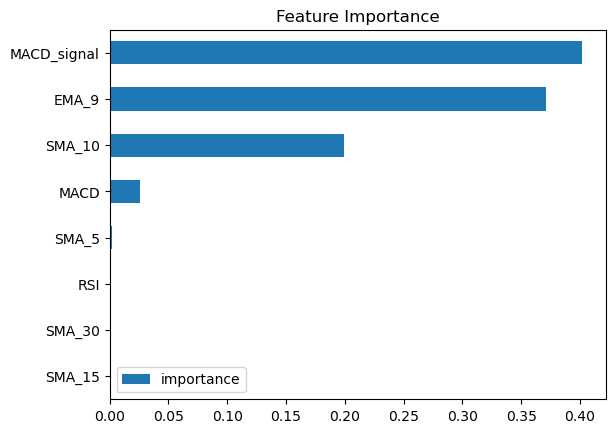

In [87]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [78]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [80]:
y_pred = ['1080.9259', '1080.9259', '1093.6593','1093.6593', '1106.9073']
predictions = pd.DataFrame(truth_df)
predictions['Close'] = y_pred

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=truth_df['Exchange Date'], 
                         y=truth_df['Close'],
                         name='Truth'))

fig.add_trace(go.Scatter(x=predictions['Exchange Date'],
                         y=predictions['Close'],
                         name='Prediction'))
fig.show()